# Blood Glucose Control - EDA

**Name:** [*Applicant name*]



### Import Data

There are multiple data sets each corresponding to a person with diabetes. Please load the files into a single data set while retaining the ability to distinguish between the PWD. 

In [1]:
import pandas as pd

df1 = pd.read_csv('../data/gluroo_500030.csv')
df2 = pd.read_csv('../data/gluroo_679372.csv')

df1.drop(columns=['sender_id'])
df2.drop(columns=['sender_id'])

df1['pid'] = 500030
df2['pid'] = 679372

df1['date'] = pd.to_datetime(df1['date'], format="mixed", utc=True)
df2['date'] = pd.to_datetime(df2['date'], format="mixed", utc=True)

# get indexes of all the meak announcements for both patients
meal_indices1 = df1[df1['msg_type'] == 'ANNOUNCE_MEAL'][df1['pid'] == 500030].index
meal_indices2 = df2[df2['msg_type'] == 'ANNOUNCE_MEAL'][df2['pid'] == 679372].index


# Initialize a new column for time since last meal (not intervention snacks) for both patients
df1['time_since_meal'] = None
df2['time_since_meal'] = None

# Loop through the patient 500030 data and calculate time since the last meal
for i in range(len(meal_indices1)):
    meal_time = df1.loc[meal_indices1[i], 'date']
    
    # Get all rows after the meal until the next meal event
    if i < len(meal_indices1) - 1:
        subsequent_readings = df1.loc[meal_indices1[i]:meal_indices1[i+1], :]
    else:
        subsequent_readings = df1.loc[meal_indices1[i]:, :]

    # Update the data
    df1.loc[subsequent_readings.index, 'time_since_meal'] = (subsequent_readings['date'] - meal_time).dt.total_seconds() / 60


# Loop through the patient 679372 data and calculate time since the last meal
for i in range(len(meal_indices2)):
    meal_time = df2.loc[meal_indices2[i], 'date']
    
    # Get all rows after the meal until the next meal event
    if i < len(meal_indices2) - 1:
        subsequent_readings = df2.loc[meal_indices2[i]:meal_indices2[i+1], :]
    else:
        subsequent_readings = df2.loc[meal_indices2[i]:, :]

    # Update the data
    df2.loc[subsequent_readings.index, 'time_since_meal'] = (subsequent_readings['date'] - meal_time).dt.total_seconds() / 60

# Now the 'time_since_meal' column should contain the time in minutes since the last meal event for both patients

#Now combine both datasets    
df = pd.concat([df1, df2], ignore_index=True)

print(df[['date', 'msg_type', 'time_since_meal']].loc[140:152, :])



/var/folders/t8/pvdjnlzj2r5295tfsct9m8l00000gn/T/ipykernel_67836/1031859708.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  meal_indices1 = df1[df1['msg_type'] == 'ANNOUNCE_MEAL'][df1['pid'] == 500030].index
/var/folders/t8/pvdjnlzj2r5295tfsct9m8l00000gn/T/ipykernel_67836/1031859708.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  meal_indices2 = df2[df2['msg_type'] == 'ANNOUNCE_MEAL'][df2['pid'] == 679372].index


                                date       msg_type time_since_meal
140 2024-05-01 16:25:29.258000+00:00            NaN       67.160033
141 2024-05-01 16:30:28.671000+00:00            NaN        72.15025
142 2024-05-01 16:31:32.223000+00:00  ANNOUNCE_MEAL             0.0
143 2024-05-01 16:35:28.774000+00:00            NaN        3.942517
144 2024-05-01 16:40:29.306000+00:00            NaN        8.951383
145 2024-05-01 16:45:29.074000+00:00            NaN       13.947517
146 2024-05-01 16:50:29.374000+00:00            NaN       18.952517
147 2024-05-01 16:55:28.589000+00:00            NaN       23.939433
148 2024-05-01 17:00:28.944000+00:00            NaN        28.94535
149 2024-05-01 17:05:29.136000+00:00            NaN        33.94855
150 2024-05-01 17:10:29.021000+00:00            NaN       38.946633
151 2024-05-01 17:15:29.068000+00:00            NaN       43.947417
152 2024-05-01 17:20:29.059000+00:00            NaN       48.947267


### Two Data Visualizations

Create at least two visualizations that are of interest to you. They can be things that would be useful information for a PWD to know, or they could be useful for informing future modeling work. If you aren't sure what to visualize try recreating common diabetes data visualizations that you can find on the internet. 

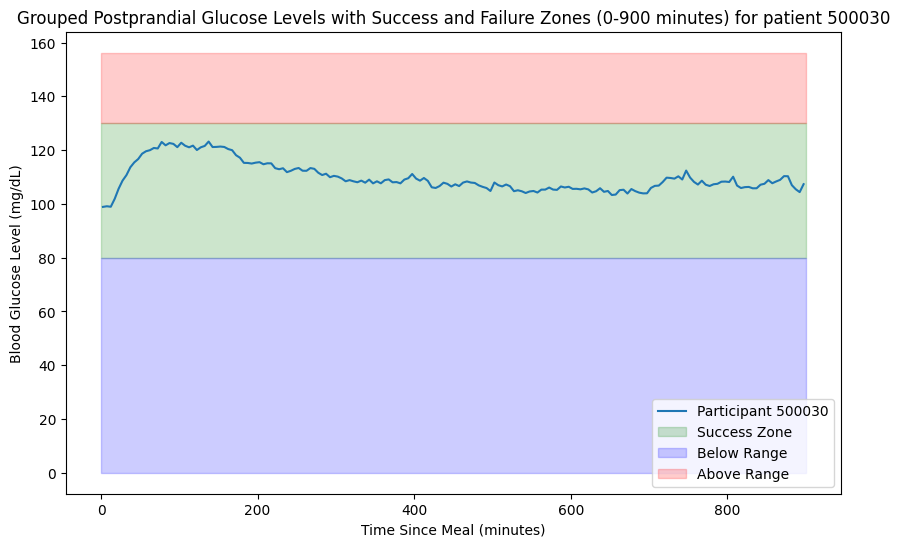

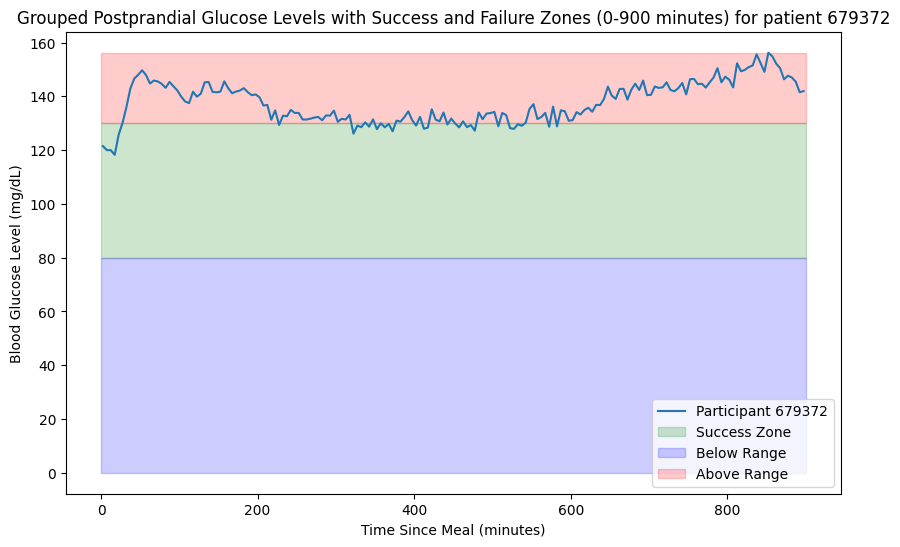

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

# Setting the time window for grouping the data in 5-minute bins/intervals
time_window = 5

# Limiting data to within a specific time range 0 to 15(900 mintues) hours after a meal
time_limit = 900

df_filtered = df[df['time_since_meal'] <= time_limit]

# Grouping data by 'pid' and 'time_since_meal' within the specified window
df_grouped = df_filtered.groupby(['pid', pd.cut(df_filtered['time_since_meal'], bins=range(0, time_limit+time_window, time_window))], observed=False)['bgl'].mean().reset_index()

# Plot the glucose levels
for i in df_grouped['pid'].unique():
    plt.figure(figsize=(10, 6))
    plt.title(f'Grouped Postprandial Glucose Levels with Success and Failure Zones (0-900 minutes) for patient {i}')
    grouped_data = df_grouped[df_grouped['pid'] == i]
    plt.plot(grouped_data['time_since_meal'].apply(lambda x: x.mid), grouped_data['bgl'], label=f'Participant {i}')

    # Define success and failure zones
    success_lower = 80
    success_upper = 130

    # Highlight the success zone
    plt.fill_between([0, time_limit], success_lower, success_upper, color='green', alpha=0.2, label='Success Zone')

    # Highlight the failure zones
    # Below Range (Failure Zone)
    plt.fill_between([0, time_limit], 0, success_lower, color='blue', alpha=0.2, label='Below Range')
    # Above Range (Failure Zone)
    plt.fill_between([0, time_limit], success_upper, df_grouped['bgl'].max(), color='red', alpha=0.2, label='Above Range')

    plt.xlabel('Time Since Meal (minutes)')
    plt.ylabel('Blood Glucose Level (mg/dL)')
    plt.legend(loc='lower right')
    plt.show()


The graphs illustrate postprandial glucose levels for two patients over time, with data grouped into bins based on a time index (0–900 minutes since the last meal). Each graph includes success and failure zones, where the success zone (80-130 mg/dL) represents the optimal postprandial glucose range, and the above range indicates hyperglycemic episodes. Patient 1 consistently remains in the success zone, suggesting that their glucose control is effective, likely influenced by a balanced diet, better insulin sensitivity, or regular physical activity. In contrast, Patient 2 frequently exceeds the success range, indicating potential factors like high-glycemic meals, insulin resistance, or lack of physical activity.From these trends, it becomes clear that dietary composition, activity levels, and intervention snacks play a role in glucose regulation. Patient 2’s frequent presence in the above range may suggest the need for better glycemic management strategies, while Patient 1's consistent performance suggests effective post-meal glucose control.

You can also see a clear trend in both the graphs. intially the blg increases but then slowly drops down between 200 to 600 minutes since last meal and then rises again. This data can be used to carefully maintain the patient's meal timings.

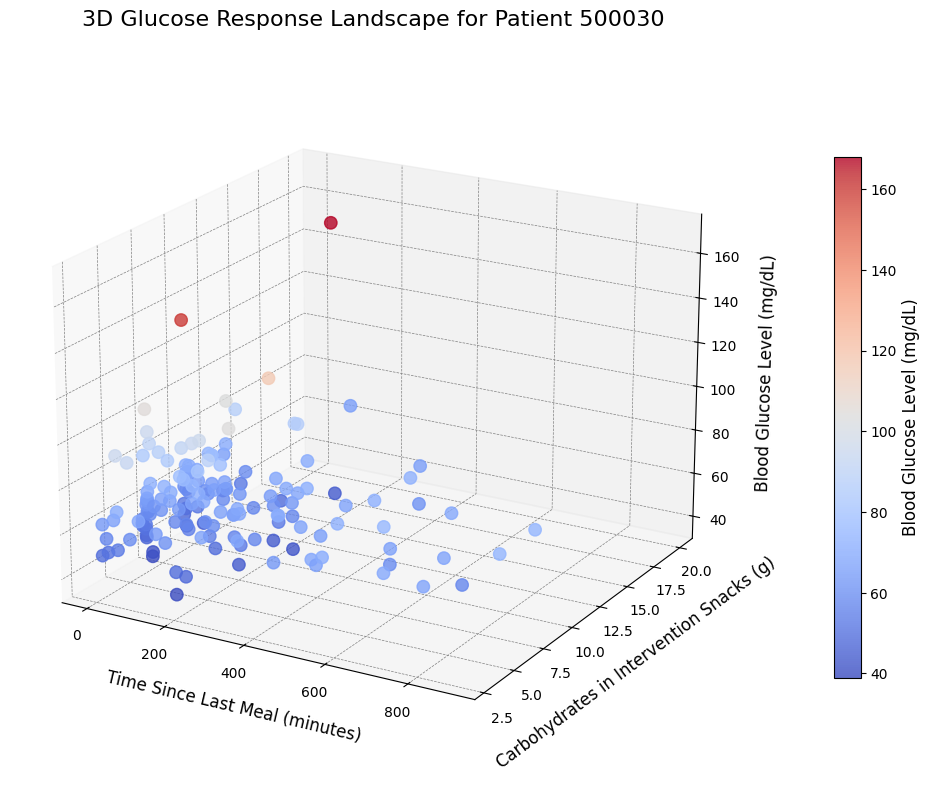

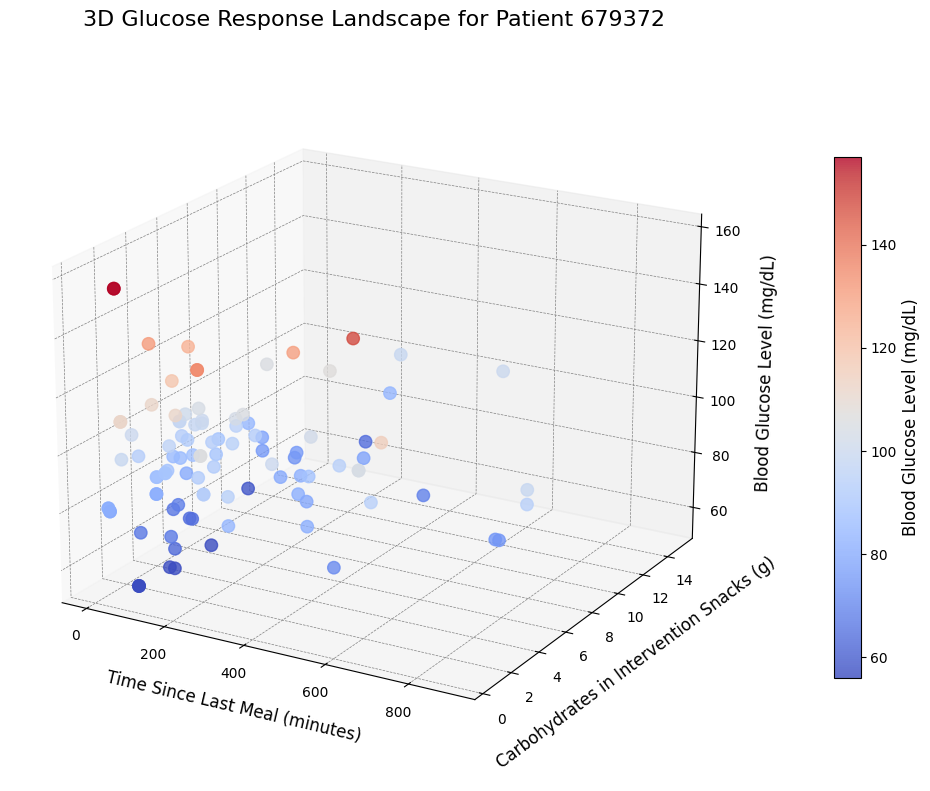

In [3]:
import matplotlib.pyplot as plt

# Filter the data for 'INTERVENTION_SNACK'
df_filtered = df[df['msg_type'] =='INTERVENTION_SNACK']

# Handle missing data if
df_clean = df_filtered.dropna(subset=['time_since_meal', 'food_g', 'bgl'])

#filter out data greater than 900 minutes since last meal
df_clean = df_clean[df_clean['time_since_meal'] <= 900]

# Separate data for each patient
patient_ids = df_clean['pid'].unique()

for patient in patient_ids:
    # Filter the data for the current patient
    df_patient = df_clean[df_clean['pid'] == patient]

    # Prepare data for the plot
    X = df_patient['time_since_meal']  # Time since meal (minutes)
    Y = df_patient['food_g']  # Grams of carbohydrates in the intervention snacks
    Z = df_patient['bgl']  # Blood glucose level (mg/dL)

    # Create the figure
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot for the 3D landscape
    sc = ax.scatter(X, Y, Z, c=Z, cmap='coolwarm', s=80, alpha=0.8)
    
    # Add color bar with better formatting
    cbar = plt.colorbar(sc, pad=0.1, aspect=20, shrink=0.7)
    cbar.set_label('Blood Glucose Level (mg/dL)', fontsize=12)
    cbar.ax.tick_params(labelsize=10)

    # Axis labels with larger font sizes
    ax.set_xlabel('Time Since Last Meal (minutes)', fontsize=12, labelpad=10)
    ax.set_ylabel('Carbohydrates in Intervention Snacks (g)', fontsize=12, labelpad=10)
    ax.set_zlabel('Blood Glucose Level (mg/dL)', fontsize=12, labelpad=10)

    # Adjust the grid for better aesthetics
    ax.grid(True, which='major', linestyle='--', linewidth=0.5)
    ax.xaxis._axinfo['grid'].update(color='gray', linestyle='--', linewidth=0.5)
    ax.yaxis._axinfo['grid'].update(color='gray', linestyle='--', linewidth=0.5)
    ax.zaxis._axinfo['grid'].update(color='gray', linestyle='--', linewidth=0.5)

    # Add title with larger font
    ax.set_title(f'3D Glucose Response Landscape for Patient {patient}', fontsize=16, pad=20)

    #styling
    ax.view_init(elev=20, azim=-60)
    plt.tight_layout()

    # Show the plot
    plt.show()


The 3D glucose response landscape for both patients continues from the previous graph where we were only checking relation between time since last meal and blg. Here I tried to check how the intervention snakcs affect the blg too along with time since last meal. The time since the last major meal is plotted on the x-axis, with carbohydrate content from intervention snacks on the y-axis, and the corresponding blood glucose level (in mg/dL) on the z-axis. The color bar visually represents glucose concentrations, where redder hues indicate higher glucose levels. 

Trends and Insights:
Patient 500030 consistently remains in the success zone, with glucose levels stabilizing within the target range of 80-140 mg/dL post-intervention. Their glucose control appears effective, possibly due to their timely intervention snacks or balanced diet. 
Patient 679372 shows more variation and frequent excursions above the success range. This could be attributed to inconsistent meal timing, carbohydrate intake from snacks, or delayed interventions. Their glucose levels rise sharply after certain meals, suggesting that their body may react more sensitively to glucose intake.
 
In both the graphs, after high-carbohydrate intake, blood glucose levels shoot up before gradually lowering evident in the few red dots near the beginning (0 - 100 minutes)

Patient Comparison: Comparing both patients, timely intervention with smaller glucose snacks plays a crucial role in controlling blood sugar levels. Patient 2 may require a more structured intervention pattern to avoid highs, especially beyond 200-300 minutes post-meal.

### Ask a question(s) about the data and/or diabetes!
When creating the visualizations you probably had some questions about managing T1D. Ask some questions that might interest you and our diabetes experts will do their best to answer them for you! *Consider this an AMAA about diabetes.* 

1. Is there a method or tool that can help fine-tune the timing and amount of intervention snacks to avoid those frustrating blood sugar roller coasters after meals? How can we use meal data and insulin together to keep blood glucose levels in normal range more consistently?

2. How much do non-food factors like stress or physical activity affect your blood sugar compared to the foods you eat? Is it easier to plan around meals, or is it more about managing everything else?

### Final Task

Thanks for showing interest in our project! We plan to incorporate the best/most interesting visualizations into a substack post in the future. 

Please remember to create a pull request with your updated template, don't forget to rename the file to something that we can identify you with, e.g: `eda_[your_name].ipynb`